In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json

In [ ]:


# read all files from folder
all_files = glob.glob(os.path.join("Data", f"*.json"))

calls = []

for filename in all_files:
    # read json file
    with open(filename, "r") as f:
        data = json.load(f)

        # append to list
        calls.append({
            "id": filename.split("/")[-1].split(".")[0],
            "call": data
        })


{'id': 'Data\\00be25b0-458f-4cbf-ae86-ae2ec1f7fba4',
 'call': [{'speaker': 'Agent',
   'text': 'Hello, is this Mr. Johnson? This is Lisa calling from XYZ Collections. How are you today?',
   'stime': 0,
   'etime': 7},
  {'speaker': 'Customer',
   'text': "I'm sorry, but I think you have the wrong person. My name is Sarah.",
   'stime': 6.5,
   'etime': 12},
  {'speaker': 'Agent',
   'text': "Oh, I apologize for the confusion, Sarah. I'm reaching out about a debt related to an outstanding balance with Definite Bank.",
   'stime': 11,
   'etime': 19},
  {'speaker': 'Customer',
   'text': "I don't have any account with Definite Bank. You might want to check your records.",
   'stime': 18,
   'etime': 24},
  {'speaker': 'Agent',
   'text': 'Thank you for letting me know. I will make a note to update our records.',
   'stime': 23,
   'etime': 30},
  {'speaker': 'Customer',
   'text': 'I appreciate that. Is there anything else I need to do?',
   'stime': 29,
   'etime': 34},
  {'speaker': '

In [14]:
def get_call_metrics(call):
    """
    Get call metrics from call data
    :param call: call data
    :return: call metrics
    """

    # get call data
    utterances = call["call"]
    silence_intervals = []
    overtalk_intervals = []
    sorted_utterances = sorted(utterances, key=lambda x: x["stime"])
    max_time = 0

    for utt in sorted_utterances:
        max_time = max(max_time, utt["etime"])

    total_duration = max_time

    # Calculate silence
    if sorted_utterances:
        if sorted_utterances[0]["stime"] > 0:
            silence_intervals.append((0, sorted_utterances[0]["stime"]))
        for i in range(len(sorted_utterances) - 1):
            if sorted_utterances[i + 1]["stime"] > sorted_utterances[i]["etime"]:
                silence_intervals.append(
                    (sorted_utterances[i]["etime"], sorted_utterances[i + 1]["stime"])
                )
        if sorted_utterances[-1]["etime"] < total_duration:
            silence_intervals.append((sorted_utterances[-1]["etime"], total_duration))
    elif total_duration > 0:
        silence_intervals.append((0, total_duration))

    # Calculate overtalk
    for i in range(len(sorted_utterances)):
        for j in range(i + 1, len(sorted_utterances)):
            utt1 = sorted_utterances[i]
            utt2 = sorted_utterances[j]
            if utt1["speaker"] != utt2["speaker"]:
                overlap_start = max(utt1["stime"], utt2["stime"])
                overlap_end = min(utt1["etime"], utt2["etime"])
                if overlap_start < overlap_end:
                    overtalk_intervals.append((overlap_start, overlap_end))

    # Calculate silence and overtalk durations
    silence_duration = sum(
        [end - start for start, end in silence_intervals]
    )
    overtalk_duration = sum(
        [end - start for start, end in overtalk_intervals]
    )

    # Calculate total duration
    total_duration = max_time

    return {
        "call_id": call["id"].split("\\")[-1].split(".")[0],
        "silence_duration": silence_duration,
        "overtalk_duration": overtalk_duration,
        "total_duration": total_duration,
        "silence_percentage": (silence_duration / total_duration) * 100 if total_duration > 0 else 0,
        "overtalk_percentage": (overtalk_duration / total_duration) * 100 if total_duration > 0 else 0,
    }

In [15]:
df = pd.DataFrame([get_call_metrics(call) for call in calls])
df["silence_duration"] = df["silence_duration"].astype(int)
df["overtalk_duration"] = df["overtalk_duration"].astype(int)
df["total_duration"] = df["total_duration"].astype(int)

df.head()

,call_id,silence_duration,overtalk_duration,total_duration,silence_percentage,overtalk_percentage
0,00be25b0-458f-4cbf-ae86-ae2ec1f7fba4,0,6,42,0.000000,15.476190
1,019b9e97-9575-459e-9893-b59d8c99acef,0,5,50,1.000000,10.400000
2,02b08433-58e0-46af-961e-221ba94cb8df,8,5,88,9.090909,5.681818
3,02f1cff9-7d47-4168-b1f9-d9fba10847a0,10,4,97,10.412371,4.639175
4,03132d8f-6a7d-47d0-9540-c6a0ac32d946,4,0,52,7.692308,0.000000


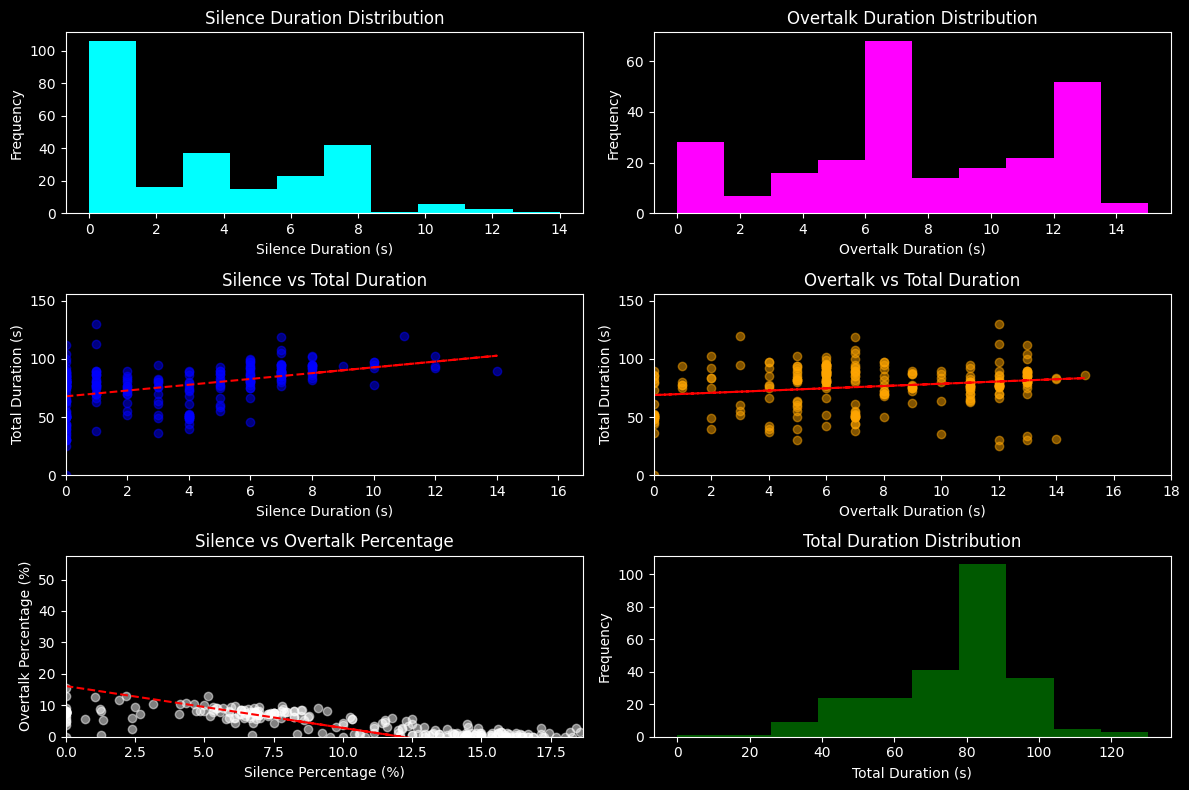

In [44]:
# visualizations

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0, 0].hist(df["silence_duration"], bins=10, color='cyan')
axs[0, 0].set_title("Silence Duration Distribution")
axs[0, 0].set_xlabel("Silence Duration (s)")
axs[0, 0].set_ylabel("Frequency")
axs[0, 1].hist(df["overtalk_duration"], bins=10, color='magenta')
axs[0, 1].set_title("Overtalk Duration Distribution")
axs[0, 1].set_xlabel("Overtalk Duration (s)")
axs[0, 1].set_ylabel("Frequency")


# silence and total duration correlation
axs[1, 0].scatter(df["silence_duration"], df["total_duration"], color="blue", alpha=0.5)
axs[1, 0].set_title("Silence vs Total Duration")
axs[1, 0].set_xlabel("Silence Duration (s)")
axs[1, 0].set_ylabel("Total Duration (s)")
axs[1, 0].set_xlim(0, max(df["silence_duration"])*1.2)
axs[1, 0].set_ylim(0, max(df["total_duration"])*1.2)
# create a linear regression line
m, b = np.polyfit(df["silence_duration"], df["total_duration"], 1)
axs[1, 0].plot(df["silence_duration"], m*df["silence_duration"] + b, color='red', linestyle='--')

# overtalk and total duration correlation
axs[1, 1].scatter(df["overtalk_duration"], df["total_duration"], color="orange", alpha=0.5)
axs[1, 1].set_title("Overtalk vs Total Duration")
axs[1, 1].set_xlabel("Overtalk Duration (s)")
axs[1, 1].set_ylabel("Total Duration (s)")
axs[1, 1].set_xlim(0, max(df["overtalk_duration"])*1.2)
axs[1, 1].set_ylim(0, max(df["total_duration"])*1.2)
# create a linear regression line
m, b = np.polyfit(df["overtalk_duration"], df["total_duration"], 1)
axs[1, 1].plot(df["overtalk_duration"], m*df["overtalk_duration"] + b, color='red', linestyle='--')



# silence and overtalk percentage correlation
axs[2, 0].scatter(df["overtalk_percentage"], df["silence_percentage"], color="white", alpha=0.5)
axs[2, 0].set_title("Silence vs Overtalk Percentage")
axs[2, 0].set_xlabel("Silence Percentage (%)")
axs[2, 0].set_ylabel("Overtalk Percentage (%)")
axs[2, 0].set_xlim(0, max(df["silence_percentage"])*1.2)
axs[2, 0].set_ylim(0, max(df["overtalk_percentage"])*1.2)
# create a linear regression line
m, b = np.polyfit(df["silence_percentage"], df["overtalk_percentage"], 1)
axs[2, 0].plot(df["silence_percentage"], m*df["silence_percentage"] + b, color='red', linestyle='--')




axs[2, 1].hist(df["total_duration"], bins=10, color='green', alpha=0.7)
axs[2, 1].set_title("Total Duration Distribution")
axs[2, 1].set_xlabel("Total Duration (s)")
axs[2, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()